In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from scipy.stats import linregress

def calc_trend(data):
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(data)), data)  
    return slope, p_value

In [3]:
# imput observational data 
obs_SAT = '/work/mh0033/m301036/josie/LSAT/1900-2022LSAT/SpatialPattern/SAT-OBS-Model/seasonalData/tas_MLOST_ano.nc'
ds_SAT = xr.open_dataset(obs_SAT)
print(ds_SAT)
# select the data from 1958-2022
MLOST_ano = ds_SAT.sel(time=slice('1958-01-01','2022-12-31'))
MLOST_ano['DJF'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='DJF').groupby('time.year').mean('time')
MLOST_ano['MAM'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='MAM').groupby('time.year').mean('time')
MLOST_ano['JJA'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='JJA').groupby('time.year').mean('time')
MLOST_ano['SON'] = MLOST_ano['air'].sel(time=MLOST_ano['time.season']=='SON').groupby('time.year').mean('time')
MLOST_ano = MLOST_ano.assign_attrs(units='degC') # fixed line

# calculate the trend of SAT
MLOST_ano['DJF_trend'],MLOST_ano['p_value_DJF'] = xr.apply_ufunc(calc_trend, MLOST_ano['DJF'], input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True)
MLOST_ano['MAM_trend'],MLOST_ano['p_value_MAM'] = xr.apply_ufunc(calc_trend, MLOST_ano['MAM'], input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True)
MLOST_ano['JJA_trend'],MLOST_ano['p_value_JJA'] = xr.apply_ufunc(calc_trend, MLOST_ano['JJA'], input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True)
MLOST_ano['SON_trend'],MLOST_ano['p_value_SON'] = xr.apply_ufunc(calc_trend, MLOST_ano['SON'], input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True)

SAT_trend = xr.Dataset({
    'DJF': MLOST_ano['DJF_trend']*65.0,
    'MAM': MLOST_ano['MAM_trend']*65.0,
    'JJA': MLOST_ano['JJA_trend']*65.0,
    'SON': MLOST_ano['SON_trend']*65.0
}, coords={'longitude': MLOST_ano['lon'], 'latitude': MLOST_ano['lat'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
SAT_trend = SAT_trend.assign_attrs(units='degC/65yr') # fixed line
print(SAT_trend)

<xarray.Dataset>
Dimensions:  (time: 1476, lon: 180, lat: 45)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2022-12-01
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Data variables:
    air      (time, lat, lon) float32 ...
<xarray.Dataset>
Dimensions:    (lon: 180, lat: 45, season: 4)
Coordinates:
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
    longitude  (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
    latitude   (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
  * season     (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    DJF        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    MAM        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    JJA        (lat, lo

In [4]:
obs_SLP = '/work/mh0033/m301036/LSAT/Data/ERA5/ERA20C-ERA5_190001-202212_rg.nc'
ds_SLP = xr.open_dataset(obs_SLP)
print(ds_SLP)

slp_obs = ds_SLP.sel(time=slice('1958-01-01','2022-12-31'),lat=slice(0,90))
slp_obs = slp_obs.assign_attrs(units='hPa') # fixed line
slp_obs = slp_obs/100.0
slp_obs

slp_obs.coords['lon'] = (slp_obs.coords['lon'] + 180) % 360 - 180
slp_obs = slp_obs.sortby(slp_obs.lon)
slp_obs

slp_obs_climatology = slp_obs.groupby('time.month').mean(dim='time')
slp_obs_climatology
slp_obs_ano = slp_obs.groupby('time.month') - slp_obs_climatology
slp_obs_ano

slp_obs_ano['DJF'] = slp_obs_ano['msl'].sel(time=slp_obs_ano['time.season']=='DJF').groupby('time.year').mean('time')
slp_obs_ano['MAM'] = slp_obs_ano['msl'].sel(time=slp_obs_ano['time.season']=='MAM').groupby('time.year').mean('time')
slp_obs_ano['JJA'] = slp_obs_ano['msl'].sel(time=slp_obs_ano['time.season']=='JJA').groupby('time.year').mean('time')
slp_obs_ano['SON'] = slp_obs_ano['msl'].sel(time=slp_obs_ano['time.season']=='SON').groupby('time.year').mean('time')

slp_obs_ano['DJF_trend'],slp_obs_ano['p_value_DJF'] = xr.apply_ufunc(calc_trend, slp_obs_ano['DJF'], input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True)
slp_obs_ano['MAM_trend'],slp_obs_ano['p_value_MAM'] = xr.apply_ufunc(calc_trend, slp_obs_ano['MAM'], input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True)
slp_obs_ano['JJA_trend'],slp_obs_ano['p_value_JJA'] = xr.apply_ufunc(calc_trend, slp_obs_ano['JJA'], input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True)
slp_obs_ano['SON_trend'],slp_obs_ano['p_value_SON'] = xr.apply_ufunc(calc_trend, slp_obs_ano['SON'], input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True)

slp_obs_trend = xr.Dataset({
    'DJF': slp_obs_ano['DJF_trend']*65.0,
    'MAM': slp_obs_ano['MAM_trend']*65.0,
    'JJA': slp_obs_ano['JJA_trend']*65.0,
    'SON': slp_obs_ano['SON_trend']*65.0
}, coords={'longitude': slp_obs_ano['lon'], 'latitude': slp_obs_ano['lat'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
slp_obs_trend = slp_obs_trend.assign_attrs(units='hPa/65yr') # fixed line

<xarray.Dataset>
Dimensions:  (time: 1476, lon: 180, lat: 90)
Coordinates:
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2022-12-01
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 83.0 85.0 87.0 89.0
Data variables:
    msl      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.6 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Jul 26 13:00:50 2023: cdo remapbil,r180x90 /work/mh0033...
    CDO:          Climate Data Operators version 2.0.6 (https://mpimet.mpg.de...


In [5]:
# imput model data
model_SAT = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/tas_Amon_1850-2100_*.nc'
ds_SAT = xr.open_mfdataset(model_SAT, combine = 'nested', concat_dim = 'run')
print(ds_SAT)
# land mask
land_sea_mask = xr.open_dataset('/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/GR15_lsm_regrid.nc')
print('land_sea_mask', land_sea_mask)

mask_data = land_sea_mask['var1']
mask_data
time_values = pd.to_datetime(mask_data['time'].values, format='mixed', dayfirst=True)
mask_data['time'] = time_values
mask_data = mask_data.reindex(time=ds_SAT['time'], method='nearest')

# Apply the land-sea mask to the original dataset
masked_tas = ds_SAT.where(mask_data == 1, drop=False)
masked_tas

tas = masked_tas['tas'].loc[:,'1958-01-01':'2022-12-31',0:90,:]
tas = tas - 273.15
print(tas.min().values)
tas_climatology = tas.groupby('time.month').mean(dim='time')
tas_climatology
tas_ano = tas.groupby('time.month') - tas_climatology
tas_ano_ds = tas_ano.to_dataset()
tas_ano_ds

#calculate the SAT anomaly
seasons = ['JJA', 'DJF', 'MAM', 'SON']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    elif season == 'MAM':
        months = [3,4,5]
    elif season == 'SON':
        months = [9,10,11]

    season_months = tas_ano_ds.sel(time=tas.time.dt.month.isin(months))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = season_months.groupby('time.year').mean('time')
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies['tas']

# Access the multiyear JJA mean SAT anomalies
    
tas_ano_ds['JJA'] = season_means['JJA']
tas_ano_ds['DJF'] = season_means['DJF']
tas_ano_ds['MAM'] = season_means['MAM']
tas_ano_ds['SON'] = season_means['SON']

tas_ano_ds

tas_ano_ds['slope_JJA'], tas_ano_ds['p_value_JJA'] = xr.apply_ufunc(calc_trend, tas_ano_ds['JJA'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_JJA'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_JJA'].attrs['units'] = 'p_value'

tas_ano_ds['slope_DJF'], tas_ano_ds['p_value_DJF'] = xr.apply_ufunc(calc_trend, tas_ano_ds['DJF'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_DJF'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_DJF'].attrs['units'] = 'p_value'

tas_ano_ds['slope_MAM'], tas_ano_ds['p_value_MAM'] = xr.apply_ufunc(calc_trend, tas_ano_ds['MAM'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_MAM'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_MAM'].attrs['units'] = 'p_value'

tas_ano_ds['slope_SON'], tas_ano_ds['p_value_SON'] = xr.apply_ufunc(calc_trend, tas_ano_ds['SON'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_ano_ds['slope_SON'].attrs['units'] = '°C/65yrs'
tas_ano_ds['p_value_SON'].attrs['units'] = 'p_value'

tas_ano_ds = tas_ano_ds.compute()
tas_ano_ds
tas_model_trend = xr.Dataset({
    'DJF': tas_ano_ds['slope_DJF']*65.0,
    'MAM': tas_ano_ds['slope_MAM']*65.0,
    'JJA': tas_ano_ds['slope_JJA']*65.0,
    'SON': tas_ano_ds['slope_SON']*65.0
}, coords={'longitude': tas_ano_ds['lon'], 'latitude': tas_ano_ds['lat'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
tas_model_trend = tas_model_trend.assign_attrs(units='°C/65yrs') # fixed line

<xarray.Dataset>
Dimensions:    (time: 3012, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
    height     float64 2.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 3012, 2), meta=np.ndarray>
    tas        (run, time, lat, lon) float32 dask.array<chunksize=(1, 3012, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    .

/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


In [6]:
# projected SAT
tas_proj = masked_tas['tas'].loc[:,'2023-01-01':'2087-12-31',0:90,:]
tas_proj = tas_proj - 273.15
print(tas_proj.min().values)
tas_proj_climatology = tas_proj.groupby('time.month').mean(dim='time')
tas_proj_climatology
tas_proj_ano = tas_proj.groupby('time.month') - tas_proj_climatology
tas_proj_ano_ds = tas_proj_ano.to_dataset()
tas_proj_ano_ds

#calculate the SAT anomaly
season_means_proj_SAT = {}
for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    elif season == 'MAM':
        months = [3,4,5]
    elif season == 'SON':
        months = [9,10,11]

    season_months = tas_proj_ano_ds.sel(time=tas.time.dt.month.isin(months))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = season_months.groupby('time.year').mean('time')
    
    # Store the seasonal mean in the dictionary
    season_means_proj_SAT[season] = season_mean_anomalies['tas']

# Access the multiyear JJA mean SAT anomalies
    
tas_proj_ano_ds['JJA'] = season_means_proj_SAT['JJA']
tas_proj_ano_ds['DJF'] = season_means_proj_SAT['DJF']
tas_proj_ano_ds['MAM'] = season_means_proj_SAT['MAM']
tas_proj_ano_ds['SON'] = season_means_proj_SAT['SON']

tas_proj_ano_ds

tas_proj_ano_ds['slope_JJA'], tas_proj_ano_ds['p_value_JJA'] = xr.apply_ufunc(calc_trend, tas_proj_ano_ds['JJA'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_proj_ano_ds['slope_JJA'].attrs['units'] = '°C/65yrs'
tas_proj_ano_ds['p_value_JJA'].attrs['units'] = 'p_value'

tas_proj_ano_ds['slope_DJF'], tas_proj_ano_ds['p_value_DJF'] = xr.apply_ufunc(calc_trend, tas_proj_ano_ds['DJF'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_proj_ano_ds['slope_DJF'].attrs['units'] = '°C/65yrs'
tas_proj_ano_ds['p_value_DJF'].attrs['units'] = 'p_value'

tas_proj_ano_ds['slope_MAM'], tas_proj_ano_ds['p_value_MAM'] = xr.apply_ufunc(calc_trend, tas_proj_ano_ds['MAM'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_proj_ano_ds['slope_MAM'].attrs['units'] = '°C/65yrs'
tas_proj_ano_ds['p_value_MAM'].attrs['units'] = 'p_value'

tas_proj_ano_ds['slope_SON'], tas_proj_ano_ds['p_value_SON'] = xr.apply_ufunc(calc_trend, tas_proj_ano_ds['SON'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
tas_proj_ano_ds['slope_SON'].attrs['units'] = '°C/65yrs'
tas_proj_ano_ds['p_value_SON'].attrs['units'] = 'p_value'

tas_proj_ano_ds = tas_proj_ano_ds.compute()
tas_proj_ano_ds
tas_proj_trend = xr.Dataset({
    'DJF': tas_proj_ano_ds['slope_DJF']*65.0,
    'MAM': tas_proj_ano_ds['slope_MAM']*65.0,
    'JJA': tas_proj_ano_ds['slope_JJA']*65.0,
    'SON': tas_proj_ano_ds['slope_SON']*65.0
}, coords={'longitude': tas_ano_ds['lon'], 'latitude': tas_ano_ds['lat'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
tas_proj_trend = tas_proj_trend.assign_attrs(units='°C/65yrs') # fixed line

-50.331924


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


In [7]:
# SLP
model_SLP = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/psl_Amon_1850-2100_*.nc'
ds_SLP = xr.open_mfdataset(model_SLP, combine = 'nested', concat_dim = 'run')
print(ds_SLP)
ds_SLP['psl'] = ds_SLP['psl']/100.0
ds_SLP['psl'] = ds_SLP['psl'].assign_attrs(units='hPa')
ds_SLP =ds_SLP.assign_coords(lon=(((ds_SLP.lon + 180) % 360) - 180)).sortby('lon')

slp_ds = ds_SLP['psl'].loc[:,'1958-01-01':'2022-12-31',0:90,:]
print(slp_ds.min().values)
slp_ds_climatology = slp_ds.groupby('time.month').mean(dim='time')
slp_ds_climatology
slp_ano_ds = slp_ds.groupby('time.month') - slp_ds_climatology
slp_ano_ds = slp_ano_ds.to_dataset()
slp_ano_ds

seasons = ['JJA', 'DJF', 'MAM', 'SON']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    elif season == 'MAM':
        months = [3,4,5]
    elif season == 'SON':
        months = [9,10,11]

    season_months = slp_ano_ds.sel(time=slp_ano_ds.time.dt.month.isin(months))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = season_months.groupby('time.year').mean('time')
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies['psl']

# Access the multiyear JJA mean SAT anomalies
    
slp_ano_ds['JJA'] = season_means['JJA']
slp_ano_ds['DJF'] = season_means['DJF']
slp_ano_ds['MAM'] = season_means['MAM']
slp_ano_ds['SON'] = season_means['SON']

slp_ano_ds

<xarray.Dataset>
Dimensions:    (time: 3012, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 3012, 2), meta=np.ndarray>
    psl        (run, time, lat, lon) float32 dask.array<chunksize=(1, 3012, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.6 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45, run: 30, year: 65)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) int64 1958 1959 1960 1961 1962 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run
Data variables:
    psl      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    JJA      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    DJF      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    MAM      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    SON      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [8]:
slp_ano_ds['slope_JJA'], slp_ano_ds['p_value_JJA'] = xr.apply_ufunc(calc_trend, slp_ano_ds['JJA'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_ds['slope_JJA'].attrs['units'] = 'hPa/65yrs'
slp_ano_ds['p_value_JJA'].attrs['units'] = 'p_value'

slp_ano_ds['slope_DJF'], slp_ano_ds['p_value_DJF'] = xr.apply_ufunc(calc_trend, slp_ano_ds['DJF'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_ds['slope_DJF'].attrs['units'] = 'hPa/65yrs'
slp_ano_ds['p_value_DJF'].attrs['units'] = 'p_value'

slp_ano_ds['slope_MAM'], slp_ano_ds['p_value_MAM'] = xr.apply_ufunc(calc_trend, slp_ano_ds['MAM'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_ds['slope_MAM'].attrs['units'] = 'hPa/65yrs'
slp_ano_ds['p_value_MAM'].attrs['units'] = 'p_value'

slp_ano_ds['slope_SON'], slp_ano_ds['p_value_SON'] = xr.apply_ufunc(calc_trend, slp_ano_ds['SON'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_ds['slope_SON'].attrs['units'] = 'hPa/65yrs'
slp_ano_ds['p_value_SON'].attrs['units'] = 'p_value'

slp_ano_ds = slp_ano_ds.compute()

slp_model_trend = xr.Dataset({
    'DJF': slp_ano_ds['slope_DJF']*65.0,
    'MAM': slp_ano_ds['slope_MAM']*65.0,
    'JJA': slp_ano_ds['slope_JJA']*65.0,
    'SON': slp_ano_ds['slope_SON']*65.0
}, coords={'longitude': slp_ano_ds['lon'], 'latitude': slp_ano_ds['lat'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
slp_model_trend = slp_model_trend.assign_attrs(units='hPa/65yr') # fixed line

In [9]:
slp_ds_proj = ds_SLP['psl'].loc[:,'2023-01-01':'2087-12-31',0:90,:]
print(slp_ds_proj.min().values)
slp_ds_proj_climatology = slp_ds_proj.groupby('time.month').mean(dim='time')
slp_ds_proj_climatology
slp_ano_proj_ds = slp_ds_proj.groupby('time.month') - slp_ds_proj_climatology
slp_ano_proj_ds = slp_ano_proj_ds.to_dataset()
slp_ano_proj_ds

seasons = ['JJA', 'DJF', 'MAM', 'SON']
season_means_proj = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    elif season == 'MAM':
        months = [3,4,5]
    elif season == 'SON':
        months = [9,10,11]

    season_months = slp_ano_proj_ds.sel(time=slp_ano_proj_ds.time.dt.month.isin(months))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = season_months.groupby('time.year').mean('time')
    
    # Store the seasonal mean in the dictionary
    season_means_proj[season] = season_mean_anomalies['psl']

# Access the multiyear JJA mean SAT anomalies
    
slp_ano_proj_ds['JJA'] = season_means_proj['JJA']
slp_ano_proj_ds['DJF'] = season_means_proj['DJF']
slp_ano_proj_ds['MAM'] = season_means_proj['MAM']
slp_ano_proj_ds['SON'] = season_means_proj['SON']

slp_ano_proj_ds

970.9191


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45, run: 30, year: 65)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-16T12:00:00 ... 2087-12-16T12:00:00
  * lon      (lon) float64 -180.0 -178.0 -176.0 -174.0 ... 174.0 176.0 178.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) int64 2023 2024 2025 2026 2027 ... 2083 2084 2085 2086 2087
Dimensions without coordinates: run
Data variables:
    psl      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    JJA      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    DJF      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    MAM      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    SON      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [10]:
slp_ano_proj_ds['slope_JJA'], slp_ano_proj_ds['p_value_JJA'] = xr.apply_ufunc(calc_trend, slp_ano_proj_ds['JJA'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_proj_ds['slope_JJA'].attrs['units'] = 'hPa/65yrs'
slp_ano_proj_ds['p_value_JJA'].attrs['units'] = 'p_value'

slp_ano_proj_ds['slope_DJF'], slp_ano_proj_ds['p_value_DJF'] = xr.apply_ufunc(calc_trend, slp_ano_proj_ds['DJF'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_proj_ds['slope_DJF'].attrs['units'] = 'hPa/65yrs'
slp_ano_proj_ds['p_value_DJF'].attrs['units'] = 'p_value'

slp_ano_proj_ds['slope_MAM'], slp_ano_proj_ds['p_value_MAM'] = xr.apply_ufunc(calc_trend, slp_ano_proj_ds['MAM'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_proj_ds['slope_MAM'].attrs['units'] = 'hPa/65yrs'
slp_ano_proj_ds['p_value_MAM'].attrs['units'] = 'p_value'

slp_ano_proj_ds['slope_SON'], slp_ano_proj_ds['p_value_SON'] = xr.apply_ufunc(calc_trend, slp_ano_proj_ds['SON'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_proj_ds['slope_SON'].attrs['units'] = 'hPa/65yrs'
slp_ano_proj_ds['p_value_SON'].attrs['units'] = 'p_value'

slp_ano_proj_ds = slp_ano_proj_ds.compute()

slp_proj_trend = xr.Dataset({
    'DJF': slp_ano_proj_ds['slope_DJF']*65.0,
    'MAM': slp_ano_proj_ds['slope_MAM']*65.0,
    'JJA': slp_ano_proj_ds['slope_JJA']*65.0,
    'SON': slp_ano_proj_ds['slope_SON']*65.0
}, coords={'longitude': slp_ano_proj_ds['lon'], 'latitude': slp_ano_proj_ds['lat'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
slp_proj_trend = slp_proj_trend.assign_attrs(units='hPa/65yr') # fixed line

In [11]:
# Define a dictionary with three keys, each representing a period
data_dict = {
    'OBS': pd.DataFrame({'SLP': slp_obs_trend['DJF'].values.flatten(), 'SAT': SAT_trend['DJF'].values.flatten()}),
    'MODEL': pd.DataFrame({'SLP': slp_model_trend['DJF'].values.flatten(), 'SAT': tas_model_trend['DJF'].values.flatten()}),
    'PROJECTION': pd.DataFrame({'SLP': slp_proj_trend['DJF'].values.flatten(), 'SAT': tas_proj_trend['DJF'].values.flatten()})
}

# Concatenate the three DataFrames into a single DataFrame, and add a new column to indicate the period
data = pd.concat([data_dict[key].assign(period=key) for key in data_dict.keys()])
data

,SLP,SAT,period
0,0.351391,NaN,OBS
1,0.384646,NaN,OBS
2,0.415378,NaN,OBS
3,0.440301,NaN,OBS
4,0.459984,NaN,OBS
...,...,...,...
242995,1.663734,NaN,PROJECTION
242996,1.651876,NaN,PROJECTION
242997,1.639909,NaN,PROJECTION
242998,1.627866,NaN,PROJECTION


ValueError: cannot reindex on an axis with duplicate labels

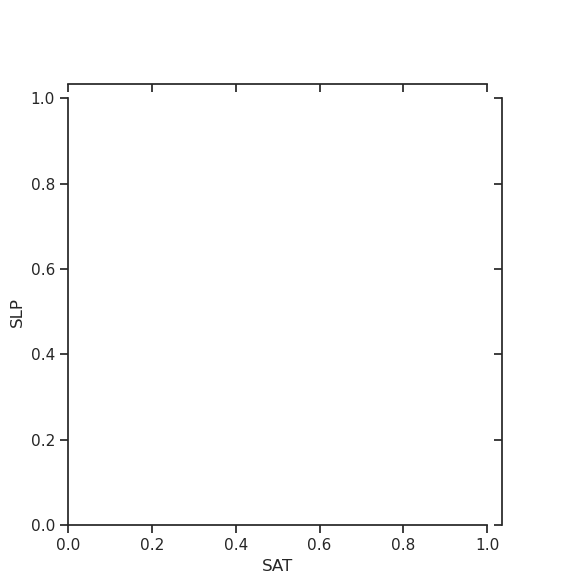

In [12]:
import seaborn as sns
sns.set_theme(style="ticks")
#create a dataframe with the trend data
# df = pd.DataFrame({'SLP': slp_obs_trend['DJF'].values.flatten(), 'SAT': SAT_trend['DJF'].values.flatten()})

# plot the joint KDE of the trend data
sns.jointplot(data=data, x='SAT', y='SLP', hue='period', kind='kde')

# overlay the joint KDE of the DJF model simulations trend data of SLP and SAT
# djf_model = pd.DataFrame({'SLP': slp_model_trend['DJF'].values.flatten(), 'SAT': tas_model_trend['DJF'].values.flatten()})
# sns.jointplot(x='SLP', y='SAT', data=djf_model, kind='kde', color='r')

plt.show()